# Introduction

<div class="alert alert-block alert-warning">
<font color=black>

**What?** PDP (implementation from scratch) - model agnostic approach for directional feature influence

</font>
</div>

# Import modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from math import ceil
from joblib import Parallel, delayed
from matplotlib.gridspec import GridSpec

# PDP = Partial Dependence Plot

<div class="alert alert-block alert-info">
<font color=black><br>

- While with tree-based method (e.g. random forest) all we get is the feature importance. 
- This tells us which feature is significantly influencing the outcome based on the importance calculation
- It does **not** inform us in which **direction** is the predictor influencing outcome.
- Partial dependence plot (PDP), a model agnostic technique that gives us an **approximate directional** influence.
- Directionality here means whether it is a positive or negative correlation.

<br></font>
</div>

# ICE = Individual Conditional Expectation Plot

<div class="alert alert-block alert-info">
<font color=black><br>

- As an extension of a PDP, ICE plot visualizes the relationship between a feature and the predicted responses for each observation. 
- While a PDP visualizes the averaged relationship between features and predicted responses, a set of ICE plots disaggregates the averaged information and visualizes an individual dependence for each observation. 
- Hence, instead of only plotting out the average predictions, ICEbox displays all individual lines. (three lines in total in this case).

<br></font>
</div>

# Load the dataset

In [3]:
data_path = '../DATASETS/titanic/train.csv'
data = pd.read_csv(data_path)
print('dimension: ', data.shape)
print('features: ', data.columns)
data.head()

dimension:  (891, 12)
features:  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# some naive feature engineering
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Embarked'] = data['Embarked'].fillna('S')
data['Sex'] = data['Sex'].apply(lambda x: 1 if x == 'male' else 0)
data = pd.get_dummies(data, columns = ['Embarked'])

# features/columns that are used
label = data['Survived']
features = [
    'Pclass', 'Sex',
    'Age', 'SibSp',
    'Parch', 'Fare',
    'Embarked_C', 'Embarked_Q', 'Embarked_S']
data = data[features]

X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size = 0.2, random_state = 1234, stratify = label)

In [4]:
# fit a baseline random forest model and show its top 2 most important features
rf = RandomForestClassifier(n_estimators = 50, random_state = 1234)
rf.fit(X_train, y_train)

print('top 2 important features:')
imp_index = np.argsort(rf.feature_importances_)
print(features[imp_index[-1]])
print(features[imp_index[-2]])

top 2 important features:
Fare
Sex


# Implementation of PDP

In [5]:
__all__ = ['PartialDependenceExplainer']


class PartialDependenceExplainer:
    """
    Partial Dependence explanation [1]_.
    - Supports scikit-learn like classification and regression classifiers.
    - Works for both numerical and categorical columns.
    Parameters
    ----------
    estimator : sklearn-like classifier
        Model that was fitted on the data.
    n_grid_points : int, default 50
        Number of grid points used in replacement
        for the original numeric data. Only used
        if the targeted column is numeric. For categorical
        column, the number of grid points will always be
        the distinct number of categories in that column.
        Smaller number of grid points serves as an
        approximation for the total number of unique
        points and will result in faster computation
    batch_size : int, default = 'auto'
        Compute partial depedence prediction batch by batch to save
        memory usage, the default batch size will be
        ceil(number of rows in the data / the number of grid points used)
    n_jobs : int, default 1
        Number of jobs to run in parallel, if the model already fits
        extremely fast on the data, then specify 1 so that there's no
        overhead of spawning different processes to do the computation
    verbose : int, default 1
        The verbosity level: if non zero, progress messages are printed.
        Above 50, the output is sent to stdout. The frequency of the messages increases
        with the verbosity level. If it more than 10, all iterations are reported.
    pre_dispatch : int or str, default '2*n_jobs'
        Controls the number of jobs that get dispatched during parallel
        execution. Reducing this number can be useful to avoid an
        explosion of memory consumption when more jobs get dispatched
        than CPUs can process. Possible inputs:
            - None, in which case all the jobs are immediately
              created and spawned. Use this for lightweight and
              fast-running jobs, to avoid delays due to on-demand
              spawning of the jobs
            - An int, giving the exact number of total jobs that are
              spawned
            - A string, giving an expression as a function of n_jobs,
              as in '2*n_jobs'
    Attributes
    ----------
    feature_name_ : str
        The input feature_name to the .fit unmodified, will
        be used in subsequent method.
    feature_type_ : str
        The input feature_type to the .fit unmodified, will
        be used in subsequent method.
    feature_grid_ : 1d ndarray
        Unique grid points that were used to generate the
        partial dependence result.
    results : list of DataFrame
        Partial dependence result. If it's a classification
        estimator then each index of the list is the result
        for each class. On the other hand, if it's a regression
        estimator, it will be a list with 1 element.
    """

    def __init__(self, estimator, n_grid_points = 50, batch_size = 'auto',
                 n_jobs = 1, verbose = 1, pre_dispatch = '2*n_jobs'):
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimator = estimator
        self.pre_dispatch = pre_dispatch
        self.n_grid_points = n_grid_points

    def fit(self, data, feature_name, feature_type):
        """
        Obtain the partial dependence result.
        Parameters
        ----------
        data : DataFrame, shape [n_samples, n_features]
            Input data to the estimator/model.
        feature_name : str
            Feature's name in the data what we wish to explain.
        feature_type : str, {'num', 'cat'}
            Specify whether feature_name is a numerical or
            categorical column.
        Returns
        -------
        self
        """

        # check whether it's a classification or regression model
        estimator = self.estimator
        try:
            n_classes = estimator.classes_.size
            is_classifier = True
            predict = estimator.predict_proba
        except AttributeError:
            # for regression problem, still set the
            # number of classes to 1 to initialize
            # the loop later downstream
            n_classes = 1
            is_classifier = False
            predict = estimator.predict

        target = data[feature_name]
        unique_target = np.unique(target)
        n_unique = unique_target.size
        if feature_type == 'num':
            if self.n_grid_points >= n_unique:
                feature_grid = unique_target
            else:
                # when the number of required grid points is smaller than the number of
                # unique values, we choose the percentile points to make sure the grid points
                # span widely across the whole value range
                percentile = np.percentile(target, np.linspace(0, 100, self.n_grid_points))
                feature_grid = np.unique(percentile)

            feature_cols = feature_grid
        else:
            feature_grid = unique_target
            feature_cols = np.asarray(['{}_{}'.format(feature_name, category)
                                       for category in unique_target])

        # compute prediction batch by batch to save memory usage
        n_rows = data.shape[0]
        batch_size = ceil(n_rows / feature_grid.size)
        parallel = Parallel(
            n_jobs = self.n_jobs, verbose = self.verbose, pre_dispatch = self.pre_dispatch)
        outputs = parallel(delayed(_predict_batch)(data_batch,
                                                   feature_grid,
                                                   feature_name,
                                                   is_classifier,
                                                   n_classes,
                                                   predict)
                           for data_batch in _data_iter(data, batch_size))
        results = []
        for output in zip(*outputs):
            result = pd.concat(output, ignore_index = True)
            result.columns = feature_cols
            results.append(result)

        self.results_ = results
        self.feature_name_ = feature_name
        self.feature_grid_ = feature_grid
        self.feature_type_ = feature_type
        return self

    def plot(self, centered = True, target_class = 0):
        """
        Use the partial dependence result to generate
        a partial dependence plot (using matplotlib).
        Parameters
        ----------
        centered : bool, default True
            Center the partial dependence plot by subtacting every partial
            dependence result table's column value with the value of the first
            column, i.e. first column's value will serve as the baseline
            (centered at 0) for all other values.
        target_class : int, default 0
            The target class to show for the partial dependence result,
            for regression task, we can leave the default number unmodified,
            but for classification task, we should specify the target class
            parameter to meet our needs
        Returns
        -------
        figure
        """
        figure = GridSpec(5, 1)
        ax1 = plt.subplot(figure[0, :])
        self._plot_title(ax1)
        ax2 = plt.subplot(figure[1:, :])
        self._plot_content(ax2, centered, target_class)
        return figure

    def _plot_title(self, ax):
        font_family = 'Arial'
        title = 'Partial Dependence Plot for {}'.format(self.feature_name_)
        subtitle = 'Number of unique grid points: {}'.format(self.feature_grid_.size)
        title_fontsize = 15
        subtitle_fontsize = 12

        ax.set_facecolor('white')
        ax.text(
            0, 0.7, title,
            fontsize = title_fontsize, fontname = font_family)
        ax.text(
            0, 0.4, subtitle, color = 'grey',
            fontsize = subtitle_fontsize, fontname = font_family)
        ax.axis('off')

    def _plot_content(self, ax, centered, target_class):
        # pd (partial dependence)
        pd_linewidth = 2
        pd_markersize = 5
        pd_color = '#1A4E5D'
        fill_alpha = 0.2
        fill_color = '#66C2D7'
        zero_linewidth = 1.5
        zero_color = '#E75438'
        xlabel_fontsize = 10

        results = self.results_[target_class]
        feature_cols = results.columns
        if self.feature_type_ == 'cat':
            # ticks = all the unique categories
            x = range(len(feature_cols))
            ax.set_xticks(x)
            ax.set_xticklabels(feature_cols)
        else:
            x = feature_cols

        # center the partial dependence plot by subtacting every value
        # with the value of the first column, i.e. first column's value
        # will serve as the baseline (centered at 0) for all other values
        pd = results.values.mean(axis = 0)
        if centered:
            pd -= pd[0]

        pd_std = results.values.std(axis = 0)
        upper = pd + pd_std
        lower = pd - pd_std

        ax.plot(
            x, pd, color = pd_color, linewidth = pd_linewidth,
            marker = 'o', markersize = pd_markersize)
        ax.plot(
            x, [0] * pd.size, color = zero_color,
            linestyle = '--', linewidth = zero_linewidth)
        ax.fill_between(x, upper, lower, alpha = fill_alpha, color = fill_color)
        ax.set_xlabel(self.feature_name_, fontsize = xlabel_fontsize)
        self._modify_axis(ax)

    def _modify_axis(self, ax):
        tick_labelsize = 8
        tick_colors = '#9E9E9E'
        tick_labelcolor = '#424242'

        ax.tick_params(
            axis = 'both', which = 'major', colors = tick_colors,
            labelsize = tick_labelsize, labelcolor = tick_labelcolor)

        ax.set_facecolor('white')
        ax.get_yaxis().tick_left()
        ax.get_xaxis().tick_bottom()
        for direction in ('top', 'left', 'right', 'bottom'):
            ax.spines[direction].set_visible(False)

        for axis in ('x', 'y'):
            ax.grid(True, 'major', axis, ls = '--', lw = .5, c = 'k', alpha = .3)


def _data_iter(data, batch_size):
    """Used by PartialDependenceExplainer to loop through the data by batch"""
    n_rows = data.shape[0]
    for i in range(0, n_rows, batch_size):
        yield data[i:i + batch_size].reset_index(drop = True)


def _predict_batch(data_batch, feature_grid, feature_name,
                   is_classifier, n_classes, predict):
    """Used by PartialDependenceExplainer to generate prediction by batch"""

    # repeat the index and use it to slice the data to create the repeated data
    # instead of creating the repetition using the values, i.e.
    # np.repeat(data_batch.values, repeats = feature_grid.size, axis = 0)
    # this prevents everything from getting converted to a different data type, e.g.
    # if there is 1 object type column then everything would get converted to object
    index_batch = np.repeat(data_batch.index.values, repeats = feature_grid.size)
    ice_data = data_batch.iloc[index_batch].copy()
    ice_data[feature_name] = np.tile(feature_grid, data_batch.shape[0])

    results = []
    prediction = predict(ice_data)
    for n_class in range(n_classes):
        if is_classifier:
            result = prediction[:, n_class]
        else:
            result = prediction

        # reshape tiled data back to original batch's shape
        reshaped = result.reshape((data_batch.shape[0], feature_grid.size))
        result = pd.DataFrame(reshaped)
        results.append(result)

    return results



# Testing

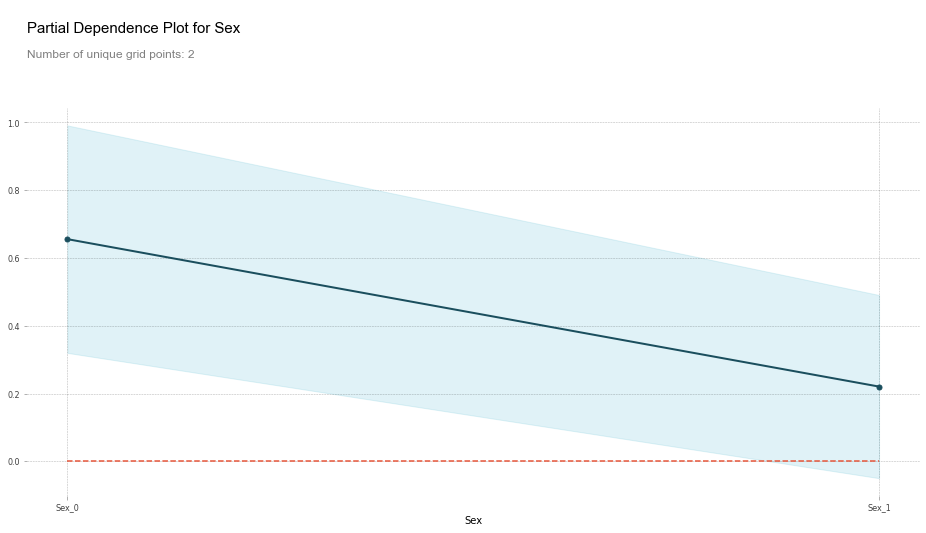

In [6]:
plt.rcParams['figure.figsize'] = 16, 9
pd_explainer = PartialDependenceExplainer(estimator = rf, verbose = 0)
pd_explainer.fit(data, feature_name = 'Sex', feature_type = 'cat')
pd_explainer.plot(centered = False, target_class = 1)
plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- The PDP makes intuitive sense, as for the categorical feature Sex, 1 indicates that the passenger was a male. 
- And we know that during the titanic accident, the majority of the survivors were female passenger, thus the plot is telling us male passengers will on average have around 40% chance lower of surviving when compared with female passengers. 
- Also instead of only plotting the "partial dependence" plot, the plot also fills between the standard deviation range. 
- This is essentially borrowing the idea from ICE plot that only plotting the average may obfuscate the relationship. 

<br></font>
</div>

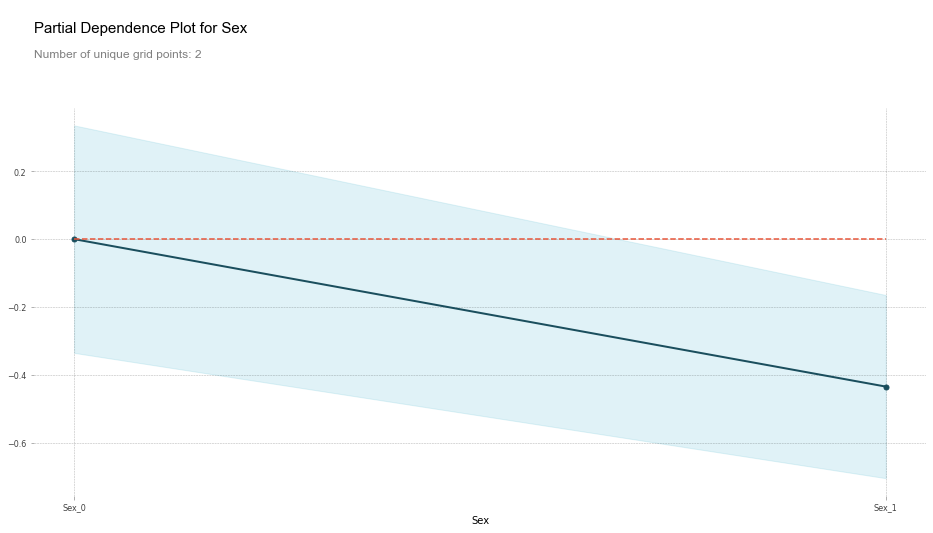

In [7]:
# centered = True is actually the default
pd_explainer.plot(centered = True, target_class = 1)
plt.show()

<div class="alert alert-block alert-info">
<font color=black><br>

- We can perform the same process for numerical features such as Fare. 
- We know that more people from the upper class survived, and people from the upper class generally have to pay more Fare to get onboard the titanic. 
- The partial dependence plot below also depicts this trend. 

<br></font>
</div>

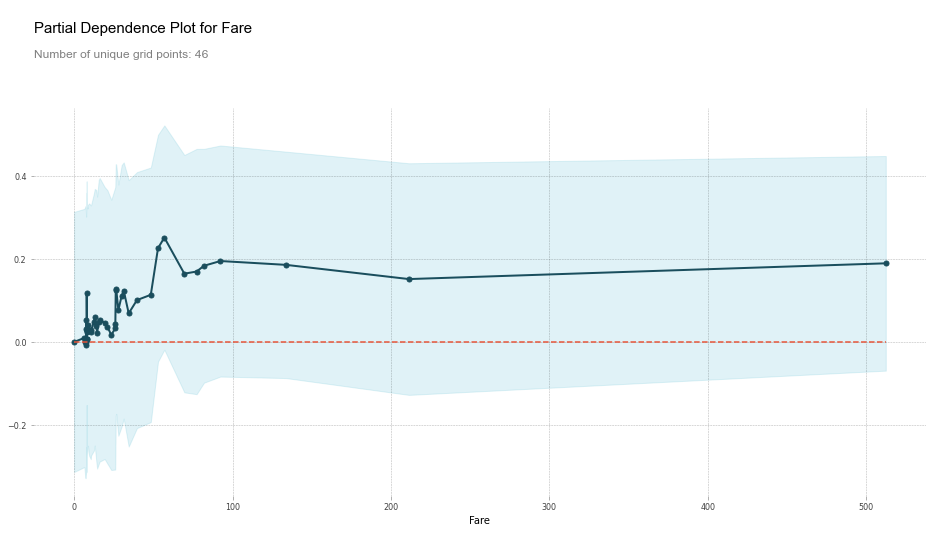

In [8]:
pd_explainer.fit(data, feature_name = 'Fare', feature_type = 'num')
pd_explainer.plot(target_class = 1)
plt.show()

# References

<div class="alert alert-block alert-warning">
<font color=black>

- [source code for the PDP class](https://github.com/ethen8181/machine-learning/blob/master/model_selection/partial_dependence/partial_dependence.ipynb<br>)
- [Blog: Introducing PDPbox](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312)
- [Online Book: Partial Dependence Plot (PDP)](https://christophm.github.io/interpretable-ml-book/pdp.html)
- [Mathworks Documentation: plotPartialDependence](https://www.mathworks.com/help/stats/regressiontree.plotpartialdependence.html?requestedDomain=true#mw_79dadf51-f451-45a9-a801-2e9ccec37aae)
- [Github: PDPbox - python partial dependence plot toolbox](https://github.com/SauceCat/PDPbox) 
- [Youtube: PyData - Random Forests Best Practices for the Business World](https://www.youtube.com/watch?v=E7VLE-U07x0&index=51&list=PLGVZCDnMOq0oqs6RTJk4zZde86DZrgnzm)
- https://github.com/SauceCat/PDPbox
- [Blog: Using Partial Dependence to Compare Sort Algorithms](http://techblog.hotwire.com/2016/06/13/partial-dependence-compare-sort/) 
                                                   
</font>
</div>